In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("diablo4_bullets_labeled_silver.csv")
df["auto_label"].value_counts()

auto_label
Buff           276
Other          187
Bugfix         176
Nerf           108
QoL             45
New Content      2
Name: count, dtype: int64

Training rows: 792
auto_label
Buff      276
Other     187
Bugfix    176
Nerf      108
QoL        45
Name: count, dtype: int64

Gold eval rows (after dropping blanks): 83
gold_label
Buff      28
QoL       24
Bugfix    21
Nerf      10
Name: count, dtype: int64

Weak supervision (rules) accuracy on gold: 0.723

Weak supervision classification report:
              precision    recall  f1-score   support

        Buff      0.800     0.571     0.667        28
        Nerf      0.500     0.800     0.615        10
         QoL      0.842     0.667     0.744        24
      Bugfix      1.000     0.952     0.976        21
       Other      0.000     0.000     0.000         0

    accuracy                          0.723        83
   macro avg      0.628     0.598     0.600        83
weighted avg      0.827     0.723     0.761        83


TF-IDF + LogisticRegression accuracy on gold: 0.723

TF-IDF classification report:
              precision    recall  f1-score   support

        Buff      0.84

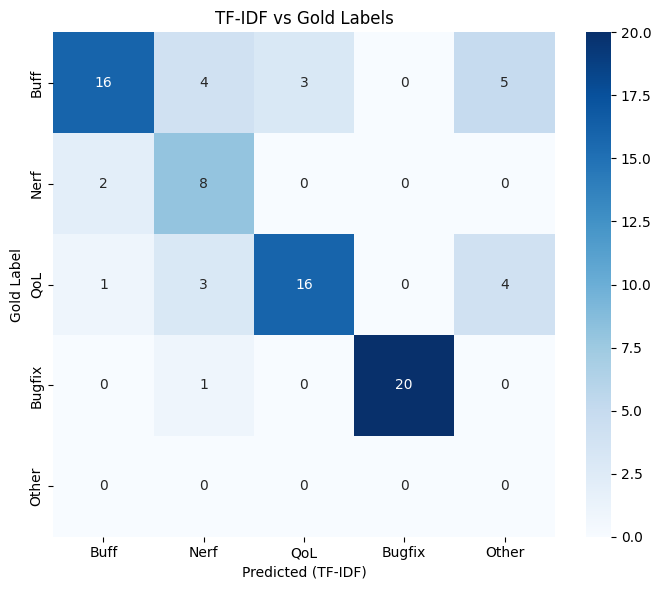


Top error pairs (gold -> predicted):
gold_label  pred_tfidf
Buff        Other         5
            Nerf          4
QoL         Other         4
Buff        QoL           3
QoL         Nerf          3
Nerf        Buff          2
Bugfix      Nerf          1
QoL         Buff          1
dtype: int64


In [4]:
# =========================
# Imports
# =========================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# seaborn is optional but nice for heatmaps
try:
    import seaborn as sns
    HAVE_SEABORN = True
except ImportError:
    HAVE_SEABORN = False


# =========================
# Config
# =========================
TRAIN_PATH = "diablo4_bullets_labeled_silver.csv"  # training data (all bullets + auto_label)
GOLD_PATH  = "gold_eval_sample_100.csv"            # evaluation subset + gold_label

# IMPORTANT: Use consistent label spellings everywhere
CANON_LABELS = ["Buff", "Nerf", "QoL", "Bugfix", "Other"]  # keep as your current 5-class setup


def normalize_label(x):
    """Normalize label strings (handles QoL vs Qol, whitespace, NaN)."""
    if pd.isna(x):
        return ""
    x = str(x).strip()
    if x.lower() == "qol":
        return "QoL"
    return x


# =========================
# Load training (silver) data
# =========================
df_train = pd.read_csv(TRAIN_PATH)

# Basic required columns check
required_train_cols = {"bullet_text", "auto_label"}
missing = required_train_cols - set(df_train.columns)
if missing:
    raise ValueError(f"Training CSV missing columns: {missing}")

df_train["auto_label"] = df_train["auto_label"].apply(normalize_label)
df_train["bullet_text"] = df_train["bullet_text"].astype(str)

# Keep only labels we care about
df_train = df_train[df_train["auto_label"].isin(CANON_LABELS)].copy()

print("Training rows:", len(df_train))
print(df_train["auto_label"].value_counts())


# =========================
# Load gold eval set
# =========================
gold_df = pd.read_csv(GOLD_PATH)

required_gold_cols = {"bullet_text", "auto_label", "gold_label"}
missing = required_gold_cols - set(gold_df.columns)
if missing:
    raise ValueError(f"Gold CSV missing columns: {missing}")

gold_df["auto_label"] = gold_df["auto_label"].apply(normalize_label)
gold_df["gold_label"] = gold_df["gold_label"].apply(normalize_label)
gold_df["bullet_text"] = gold_df["bullet_text"].astype(str)

# Drop blank/ambiguous gold labels (this is expected in your workflow)
gold_df = gold_df[(gold_df["gold_label"] != "")].copy()

# Keep only eval labels we care about
gold_df = gold_df[gold_df["gold_label"].isin(CANON_LABELS)].copy()

print("\nGold eval rows (after dropping blanks):", len(gold_df))
print(gold_df["gold_label"].value_counts())


# =========================
# Weak supervision baseline on gold
# =========================
ws_acc = accuracy_score(gold_df["gold_label"], gold_df["auto_label"])
print(f"\nWeak supervision (rules) accuracy on gold: {ws_acc:.3f}")

print("\nWeak supervision classification report:")
print(classification_report(
    gold_df["gold_label"],
    gold_df["auto_label"],
    labels=CANON_LABELS,
    digits=3,
    zero_division=0
))


# =========================
# Train TF-IDF + Logistic Regression on SILVER labels
# =========================
X_train_text = df_train["bullet_text"].values
y_train = df_train["auto_label"].values

# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1, 2),     # unigrams + bigrams usually helps a lot on patch-note phrasing
    min_df=2,               # drop super-rare terms
    max_df=0.95,            # drop extremely common terms
    sublinear_tf=True
)

X_train_vec = tfidf.fit_transform(X_train_text)

clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",   # helps with imbalance (e.g., fewer Nerfs)
    n_jobs=None                # keep None for Windows compatibility
)

clf.fit(X_train_vec, y_train)


# =========================
# Evaluate TF-IDF model on GOLD labels
# =========================
X_gold_vec = tfidf.transform(gold_df["bullet_text"].values)
y_gold = gold_df["gold_label"].values

pred = clf.predict(X_gold_vec)

acc = accuracy_score(y_gold, pred)
print(f"\nTF-IDF + LogisticRegression accuracy on gold: {acc:.3f}")

print("\nTF-IDF classification report:")
print(classification_report(
    y_gold,
    pred,
    labels=CANON_LABELS,
    digits=3,
    zero_division=0
))


# =========================
# Confusion matrix plot
# =========================
cm = confusion_matrix(y_gold, pred, labels=CANON_LABELS)

plt.figure(figsize=(7, 6))
if HAVE_SEABORN:
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=CANON_LABELS, yticklabels=CANON_LABELS)
else:
    plt.imshow(cm, cmap="Blues")
    plt.xticks(range(len(CANON_LABELS)), CANON_LABELS, rotation=45, ha="right")
    plt.yticks(range(len(CANON_LABELS)), CANON_LABELS)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted (TF-IDF)")
plt.ylabel("Gold Label")
plt.title("TF-IDF vs Gold Labels")
plt.tight_layout()
plt.show()


# =========================
# (Optional) Show top error pairs
# =========================
err_df = gold_df.copy()
err_df["pred_tfidf"] = pred
errors = err_df[err_df["pred_tfidf"] != err_df["gold_label"]]

print("\nTop error pairs (gold -> predicted):")
print(
    errors.groupby(["gold_label", "pred_tfidf"])
          .size()
          .sort_values(ascending=False)
          .head(15)
)
